In [1]:
#NOTE - UPLOAD DATA FILES TO YOUR NOTEBOOK TO USE FILENAME FORMAT AS IS IN THE DICTIONARY
#OTHERWISE, CHANGE THE DICTIONARY VALUES
%matplotlib notebook
import mne
import numpy as np

import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn import linear_model

In [10]:
def importFiles(edf, log):
    montage = mne.channels.read_montage('standard_1020')
    edf_file = edf
    log_file = log
    return edf_file, log_file
    

def readRaw(edf_file):
    montage = mne.channels.read_montage('standard_1020')
    raw = mne.io.read_raw_edf(edf_file, stim_channel='Trigger', eog=['EEG X1-Pz'], 
                              misc=['EEG CM-Pz','EEG X2-Pz','EEG X3-Pz'])
    # Rename the channels so they match the standard montage channel names
    raw.rename_channels({c:c.replace('EEG ','').replace('-Pz','') for c in raw.ch_names})
    raw.set_montage(montage)
    eeg_sample_interval_ms = 1/raw.info['sfreq'] * 1000
    return raw, eeg_sample_interval_ms
    
def cleanLogDf(log_file, shift_ind):
    logdf = pd.read_csv(log_file, header=None, names=['client_ts','trigger_ts','rtdelay','msg','uid'])
    logdf.client_ts = (logdf.client_ts * 1000).round().astype(int)
    logdf.trigger_ts = (logdf.trigger_ts * 1000).round().astype(int)
    logdf['bytecode'] = logdf.client_ts % 255 + 1
    #logdf['trigger_ts'] = logdf['trigger_ts'] + (logdf.at[0, 'client_ts'] - logdf.at[0, 'trigger_ts'])
    logdf = logdf[shift_ind:] #FOR THE FIRST EEG
    return logdf

def parseEvents(raw):
    events = mne.find_events(raw, min_duration=2/raw.info['sfreq'])
    eventdf = pd.DataFrame(events, columns=['time_idx','prev_diff','bytecode'])
    event_start_ts = int(raw.info['meas_date'][0]) + 7*60*60
    eventdf['eeg_ts'] = ((eventdf.time_idx / 300 + event_start_ts) * 1000).round().astype(int)
    #eventdf.to_csv('riaJuly8Test1Events.csv')
    np.sort(pd.unique(eventdf.bytecode))
    #eventdf =eventdf[:340]
    return eventdf, event_start_ts

def findMatches(eventdf, logdf, byte, shft_ind):
    window = 10000 # +/-, in milliseconds
    shift_idx = shft_ind
    match_inds = []

    #ADD COMPARE FUNCTION TO RETURN TRUE IF BYTECODES ARE EXACTLY EQUAL OR OFF BY FOUR
    for event_idx in eventdf.index:
        tmp = logdf.loc[np.abs(eventdf.eeg_ts[event_idx] - logdf.client_ts) < window, :]
        matches = tmp.index[(tmp.bytecode == eventdf.bytecode[event_idx]) | (tmp.bytecode==(eventdf.bytecode[event_idx]-byte))]
        if len(matches) > 0:
            for match in matches:
                # See if the surrounding bytecodes match. If so, add this to the list
                keep = False
                try:
                    keep = True
                    for idx in range(-shift_idx,shift_idx+1):
                        if (tmp.bytecode[match + idx] != eventdf.bytecode[event_idx + idx] | tmp.bytecode[match + idx]!=(eventdf.bytecode[event_idx + idx]-byte)):
                            keep = False
                            continue
                except:
                    #print(tmp.bytecode[match[0]+1], eventdf.bytecode[event_idx+1])
                    pass
                if keep:
                    match_inds.append((logdf.msg[match], match, event_idx, logdf.trigger_ts[match], logdf.client_ts[match],
                                        eventdf.eeg_ts[event_idx], eventdf.time_idx[event_idx], logdf.rtdelay[match]))

    print('Found %d matching timepoints.' % len(match_inds))
    cols = ['msg','logdf_idx','eventdf_idx','trigger_ts','client_ts','eeg_ts','eeg_samp','rt_delay']
    matchdf = pd.DataFrame(data=match_inds, columns=cols)
    matchdf = matchdf.sort_values('client_ts').reset_index(drop=True)
    matchdf.loc[matchdf.rt_delay <= 0, 'rt_delay'] = np.nan
    return matchdf

def fit_timestamps(matchdf, msgs, logdf, mad_scale, event_start_ts, correct_delay, plot):
    tmp = matchdf.copy(deep=True).loc[matchdf.msg.isin(msgs),:]
    tmp.reset_index(inplace=True)
    tmp['netdelay'] = np.nan
    # the round-trip delay stored in row n is actually for row n-1 
    tmp['netdelay'] = tmp.rt_delay.shift(-1) / 2
    # mean-fill the net delay
    delay_mean = tmp.netdelay.median()
    delay_std = tmp.netdelay.std()
    tmp.netdelay.fillna(delay_mean, inplace=True)
    
    # The eeg timestamps are shifted back in time, as if there were no network delay. This 
    # leaves the clock bias as only difference (on average) between the eeg and client timestamps.
    x = tmp.client_ts.values
    if correct_delay:
        y = tmp.eeg_ts.values - delay_mean
        #y = tmp.eeg_ts.values - tmp.netdelay
        # FIXME-- should be tmp.netdelay, but we may have an issue with rt_times
    else:
        y = tmp.eeg_ts.values
    # WORK HERE: 
    # Offset includes clock bias (same for all measurements) and the timing error for this one measurment.
    # The intercept in the fitted model *should* take care of this, but may require more thought to be sure.
    offset = y[0]
    x = x - offset
    y = y - offset

    X = np.atleast_2d(x).T

    # Robust linear fit
    thresh = (np.abs(y - y.mean())).mean() / mad_scale
    client_to_eeg = linear_model.RANSACRegressor(residual_threshold=thresh)
    client_to_eeg.fit(X, y)
    
    x_keep = logdf.client_ts[logdf.msg.isin(msgs)].values - offset
    predicted_eeg_ts = (client_to_eeg.predict(np.atleast_2d(np.array(x_keep)).T) + offset - event_start_ts*1000) 
    predicted_eeg_samp = (predicted_eeg_ts / (1000/300)).round().astype(int)
    # Predict data of estimated models
    if plot:
        y_hat = client_to_eeg.predict(np.atleast_2d(x).T) 
        plt.plot(x, y, 'ro', x, y_hat, 'k-')
        #print('x0=%d, y0=%d, y_hat0=%d, offset=%d' % (x[0],y[0],int(round(y_hat[0])),offset))
        #print(client_to_eeg.estimator_.coef_[0], client_to_eeg.estimator_.intercept_)
        outliers = np.argwhere(client_to_eeg.inlier_mask_ == False).flatten()
        #print(','.join([str(v) for v in outliers]))
    #print('using %s (options are: %s)' % (','.join(msgs), ', '.join(pd.unique(matchdf.msg))))
    outmask = client_to_eeg.inlier_mask_ == False
    #print('Rejecting %d out of %d sample pairs.' % (outmask.sum(), len(outmask)))
    #print('Mean network delay: %0.2f ms (%0.2f stdev)' % (delay_mean, delay_std))
    return predicted_eeg_samp,client_to_eeg,offset

def getPredictedTimes(matchdf, logdf, event_start_ts):
    msgs = ['normal', 'oddball'] #'normal', 'oddball' 'imageFlip'
    mad_scale = 10
    predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, logdf, mad_scale, event_start_ts, True,False)
    return np.unique(predicted_eeg_samp),client_to_eeg,offset

def getEvokedPot(predicted_eeg_samp,client_to_eeg,offset, myBias, raw):
    bias = int(round(myBias / (1/.3)))
    #predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, mad_scale=mad_scale, correct_delay=True)
    syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
    raw_no_ref,_ = mne.set_eeg_reference(raw.load_data().filter(l_freq=None, h_freq=45), [])
    #raw_no_ref, _ = mne.set_eeg_reference(raw.load_data(), [])
    reject = dict(eeg=150e-6) # 180e-6, eog=150e-6)
    event_id, tmin, tmax = {'visual': 1}, -0.10, 0.5
    epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
    evoked_no_ref = mne.Epochs(raw_no_ref, **epochs_params).average()
    syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
    epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
    evoked_no_ref_uncorrected = mne.Epochs(raw_no_ref, **epochs_params).average()
    return evoked_no_ref_uncorrected

def createPlot(evoked_no_ref_uncorrected):
    return evoked_no_ref_uncorrected.plot(time_unit='ms', spatial_colors=True)

def showVEP(subject):
    edf = subject['eegFile']
    log = subject['logFile']
    shift = subject['shiftIndex']
    bias = subject['bias']
    byte = subject['badByte']
    shftInd = subject['shft_ind']
    edfDf, logDf = importFiles(edf, log)
    raw,eeg_sample_interval_ms = readRaw(edfDf)
    logdf = cleanLogDf(logDf, shift)
    eventdf, event_start_ts = parseEvents(raw)
    matchdf = findMatches(eventdf, logdf, byte,shftInd)
    predicted_eeg_samp,client_to_eeg,offset = getPredictedTimes(matchdf, logdf, event_start_ts)
    evoked_no_ref_uncorrected = getEvokedPot(predicted_eeg_samp,client_to_eeg,offset, bias, raw)
    createPlot(evoked_no_ref_uncorrected)
    

In [11]:
subject1 = {'eegFile':'eeg0001_raw.edf', 'logFile':'EEG_0001.csv', 'shiftIndex':2, 'bias':150, 'badByte':4, 'shft_ind':2}
#Good VEP signal, good audio evoked except for major drift in 02 channel, and bad bias shift

subject2 = {'eegFile':'eeg0002_raw.edf', 'logFile':'EEG_0002.csv', 'shiftIndex':7, 'bias':150, 'badByte':4, 'shft_ind':2}
#very minimal VEP, a lot of drift across most channels. OK audio potential, still a lot of drift

subject3 = {'eegFile':'eeg0003_raw.edf', 'logFile':'EEG_0003.csv', 'shiftIndex':0, 'bias':300, 'badByte':4, 'shft_ind':2}
#Very weak but present VEP with F4 channel drift, but good audio evoked 

subject4 = {'eegFile':'eeg0004_raw.edf', 'logFile':'EEG_0004.csv', 'shiftIndex':0, 'bias':150, 'badByte':4, 'shft_ind':2}
#SUBJECT4 USE picks=['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'CM', 'F7', 'A1'],  IN PLOT PARAMETER
#Weak but present VEP when plot parameter picks used as some channels had horrible drift.
#Good audio evoked under the same plot parameter

subject5 = {'eegFile':'eeg0005_raw.edf', 'logFile':'EEG_0005.csv', 'shiftIndex':0, 'bias':200, 'badByte':0, 'shft_ind':2}
#Great VEP, besides major drift in A1 channel. Good audio evoked with drift towards the end of the 500ms window

subject6 = {'eegFile':'eeg0006_raw.edf', 'logFile':'EEG_0006.csv', 'shiftIndex':0, 'bias':200, 'badByte':0, 'shft_ind':2}
#good VEP early, but major drift right after the P100. good audio evoked potential

subject7  = {'eegFile':'eeg0007_raw.edf', 'logFile':'EEG_0007.csv', 'shiftIndex':0, 'bias':100, 'badByte':0, 'shft_ind':2}
#VEP messed up, weak audio potential

subject8  = {'eegFile':'eeg0008_raw.edf', 'logFile':'EEG_0008.csv', 'shiftIndex':0, 'bias':100, 'badByte':0, 'shft_ind':2}
#Good VEP, good audio, need bias

subject9  = {'eegFile':'eeg0009_raw.edf', 'logFile':'EEG_0009.csv', 'shiftIndex':1, 'bias':100, 'badByte':0, 'shft_ind':0}
#Great VEP, drift on C4 channel with audio

subject10  = {'eegFile':'eeg0010_raw.edf', 'logFile':'0010_log.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#weak vep, incredible audio

subject11  = {'eegFile':'eeg0011_raw.edf', 'logFile':'0011_log.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#weak vep, good audio with drift in F8 channel

subject12  = {'eegFile':'eeg0012_raw.edf', 'logFile':'0012_log.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#good vep with big drift at the end, good audio with drift towards the end

subject13  = {'eegFile':'eeg0013_raw.edf', 'logFile':'EEG_0013.csv', 'shiftIndex':0, 'bias':50, 'badByte':0, 'shft_ind':0}
#ok vep, lots of drift after the initial vep. good audio with lots of drift in f7

subject14  = {'eegFile':'eeg0014_raw.edf', 'logFile':'EEG_0014.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#awful vep, lots of drift. great audio

subject15  = {'eegFile':'eeg0015_raw.edf', 'logFile':'EEG_0015.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#good vep, lots of drift after the initial vep. good audio

subject16  = {'eegFile':'eeg0016_raw.edf', 'logFile':'EEG_0016.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#ok vep, lots of drift in c3. great audio

subject17  = {'eegFile':'eeg0017_raw.edf', 'logFile':'EEG_0017.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#bad/no vep, lots of drift after initial 100ms, good audio with lots of drift in F7

subject18  = {'eegFile':'eeg0018_raw.edf', 'logFile':'EEG_0018.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#ok vep once bias is figured out, good audio once bias is figured out

subject19  = {'eegFile':'eeg0019_raw.edf', 'logFile':'EEG_0019.csv', 'shiftIndex':0, 'bias':150, 'badByte':0, 'shft_ind':0}
#incredible vep (interesting note, the guy accidentally did the image flip twice... looks really clean)
#great audio but drift in 01 channel


Extracting EDF parameters from /Users/ctananbaum/eeg0019_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
1109 events found
Event IDs: [  1   2   3   8   9  10  11  16  17  18  19  24  25  26  27  32  33  34
  35  40  41  42  43  48  49  50  51  56  57  58  59  64  65  66  67  72
  73  74  75  80  81  82  83  88  89  90  91  96  97  98  99 104 105 106
 107 112 113 114 115 120 121 122 123 128 129 130 131 136 137 138 139 144
 145 146 147 152 153 154 155 160 161 162 163 168 169 170 171 176 177 178
 179 184 185 186 187 192 193 194 195 200 201 202 203 208 209 210 211 216
 217 218 219 224 225 226 227 232 233 234 235 240 241 242 243 248 249 250
 251]
Found 531 matching timepoints.
Reading 0 ... 817649  =      0.000 ...  2725.497 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design 

<IPython.core.display.Javascript object>


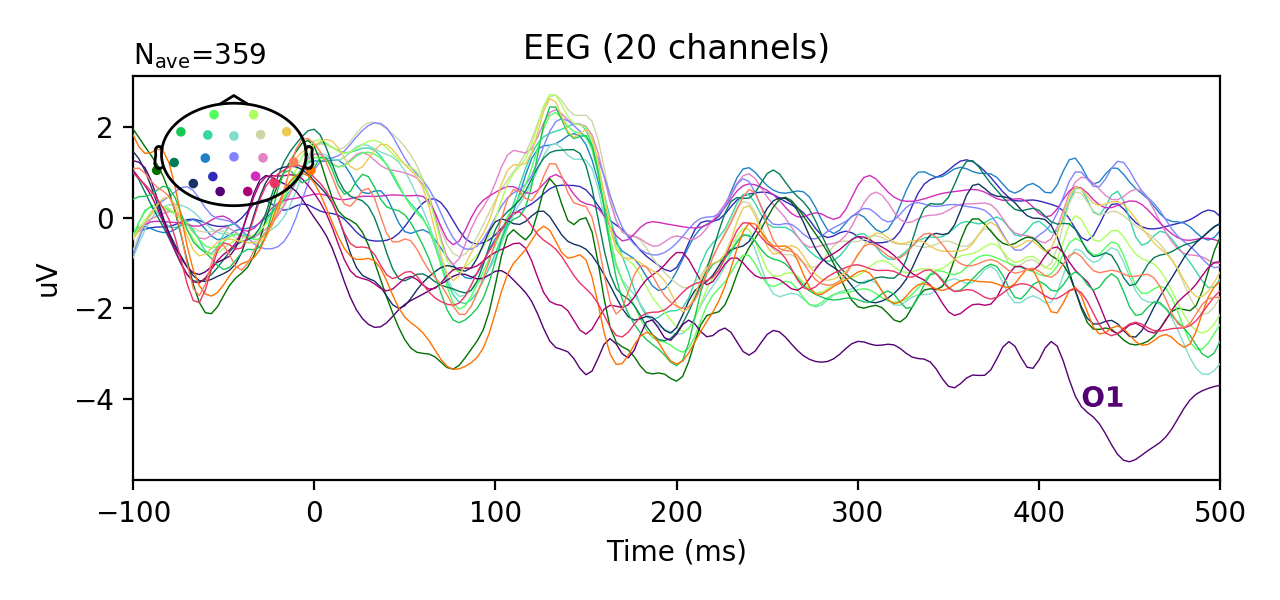

In [15]:
showVEP(subject19)